In [1]:
## ALL IMPORTS FOR A NEW NOTEBOOK
__SEED = 0
__N_FOLDS = 5
__NROWS = None

import os, sys, random, math
import matplotlib.pyplot as plt
# %matplotlib inline
plt.style.use('ggplot')

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)
import matplotlib.pylab as plt
import seaborn as sns
import itertools as it
import scipy
import glob
import matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch.optim import Optimizer
import torchvision.transforms.transforms as txf
import torch.optim.lr_scheduler as lr_scheduler
from collections import OrderedDict

from sklearn import metrics
from sklearn import preprocessing as pp
from sklearn import model_selection as ms

import ml_utils as mutils
import time, datetime, pickle


# fold1 = ms.StratifiedKFold(n_splits=__N_FOLDS, shuffle=True, random_state=__SEED)
# fold2 = ms.StratifiedKFold(n_splits=__N_FOLDS, shuffle=True, random_state=__SEED+3)
# fold3 = ms.StratifiedKFold(n_splits=__N_FOLDS, shuffle=True, random_state=__SEED+5)
font = {'size'   : 14}
matplotlib.rc('font', **font)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
train = pd.read_csv("./train.csv", index_col="id")
test = pd.read_csv("./test.csv", index_col="id")

train["ord_6"] = train["ord_5"].str[1]
train["ord_5"] = train["ord_5"].str[0]
train["bin_3"] = train["bin_3"].map({"F":0, "T":1})
train["bin_4"] = train["bin_4"].map({"N":0, "Y":1})

test["ord_6"] = test["ord_5"].str[1]
test["ord_5"] = test["ord_5"].str[0]
test["bin_3"] = test["bin_3"].map({"F":0, "T":1})
test["bin_4"] = test["bin_4"].map({"N":0, "Y":1})

In [10]:
stats,_,_ = mutils.summarize_categorical(train, test, exclude_feat=["target"], target_for_cramerV="target")
stats

,Feature,Target Cramer's V,Unique values (Train),Unique values (Test),Train only value counts,Test only value counts,Missing (Train),Missing (Test),Value with the highest counts (Train),DataType
0,bin_0,0.060,2,2,0(0.0),0(0.0),17894(2.982),17894(2.982),0.0(88.063),float64
1,bin_1,0.018,2,2,0(0.0),0(0.0),18003(3.0),18003(3.0),0.0(79.003),float64
2,bin_2,0.066,2,2,0(0.0),0(0.0),17930(2.988),17930(2.988),0.0(69.974),float64
3,bin_3,0.001,2,2,0(0.0),0(0.0),18014(3.002),18014(3.002),0.0(61.035),float64
4,bin_4,0.019,2,2,0(0.0),0(0.0),18047(3.008),18047(3.008),0.0(52.057),float64
5,nom_0,0.016,3,3,0(0.0),0(0.0),18252(3.042),18252(3.042),Red(53.881),object
6,nom_1,0.071,6,6,0(0.0),0(0.0),18156(3.026),18156(3.026),Triangle(27.365),object
7,nom_2,0.046,6,6,0(0.0),0(0.0),18035(3.006),18035(3.006),Hamster(27.483),object
8,nom_3,0.060,6,6,0(0.0),0(0.0),18121(3.02),18121(3.02),India(27.478),object
9,nom_4,0.042,4,4,0(0.0),0(0.0),18035(3.006),18035(3.006),Theremin(51.437),object


<Figure size 432x288 with 0 Axes>

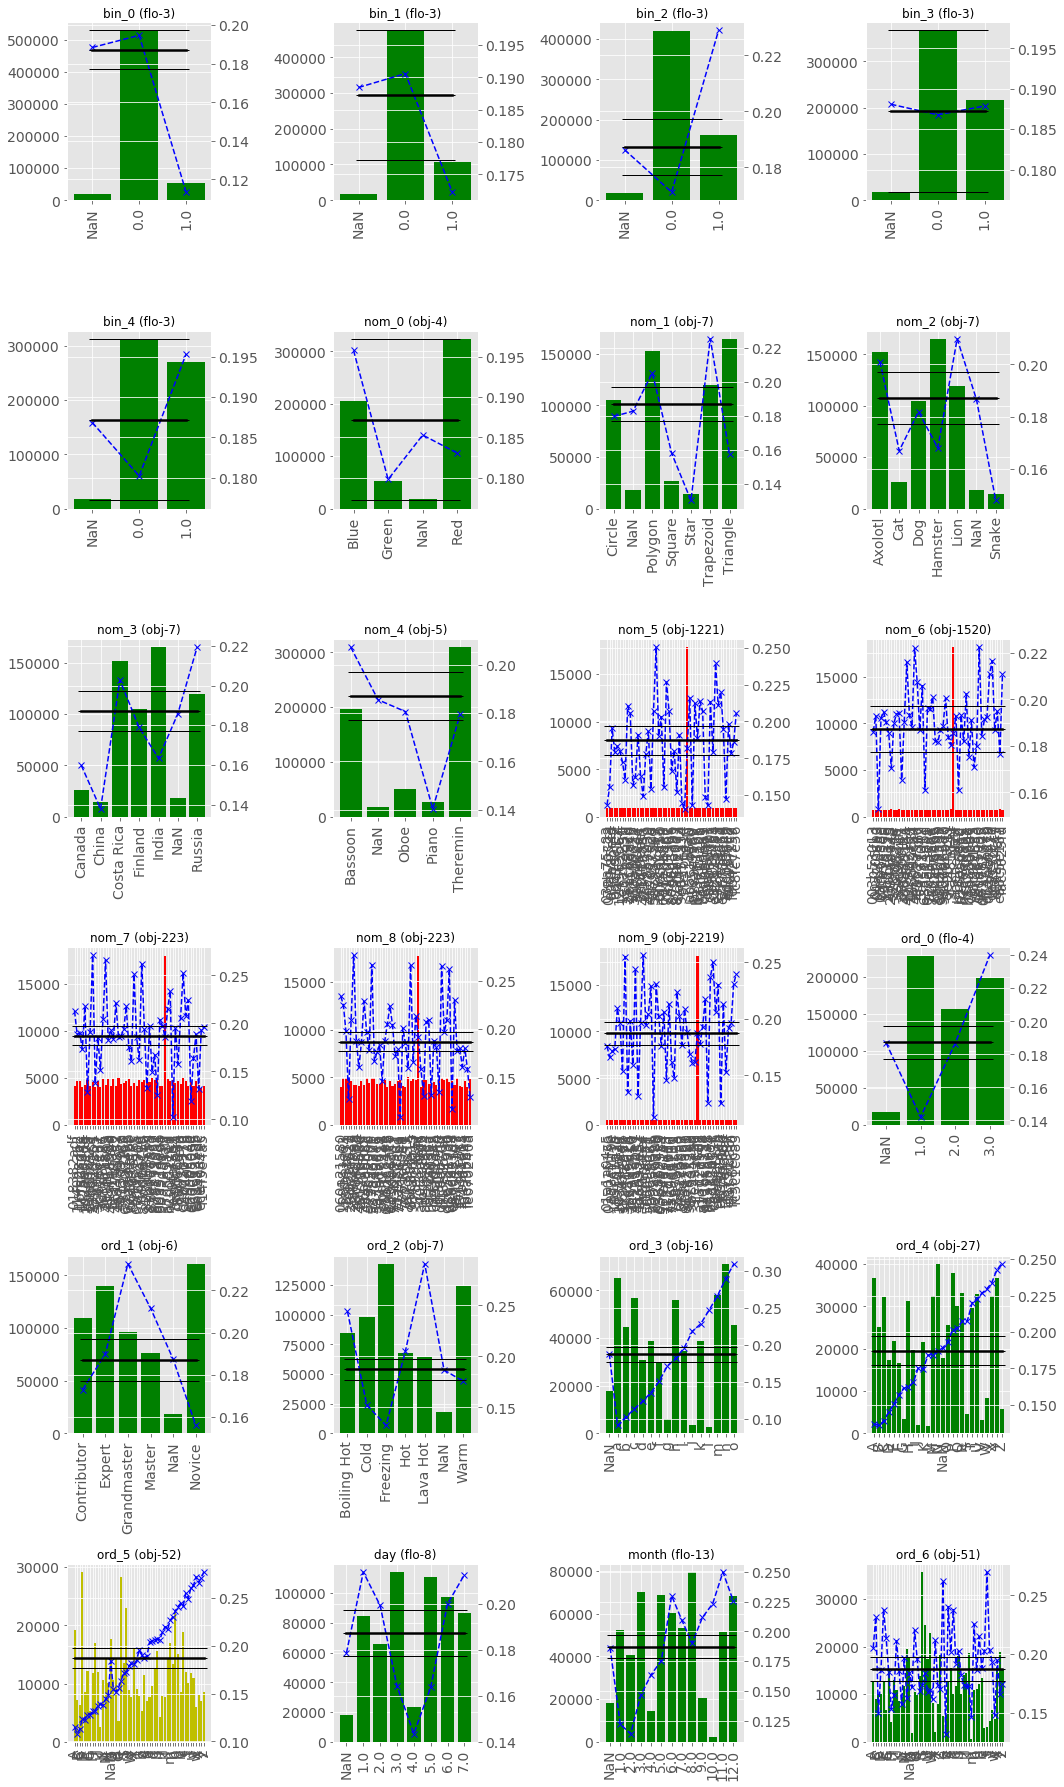

In [11]:
mutils.plot_multiple_categorical(train, [c for c in train.columns if c not in ["target"]], col_target='target', top_n=51)